In [1]:
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.schema.runnable import RunnableLambda,RunnablePassthrough, RunnableMap
from langchain.embeddings import OpenAIEmbeddings
import os
from dotenv import load_dotenv
from bs4 import BeautifulSoup as Soup
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

In [2]:
from langsmith import utils
from langsmith import traceable

In [3]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
# define your langchain project name here
os.environ["LANGCHAIN_PROJECT"] = "EI Assistant"

In [4]:
load_dotenv()
OPENAI_API = os.getenv('OPENAI_API_KEY')
LANGCHAIN_API = os.getenv('LANGCHAIN_API_KEY')
mem0_API = os.getenv('mem0_API_KEY')
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

# Initialize your retriever (example using FAISS)
# Load
url = "https://www.canada.ca/en/employment-social-development/programs/ei/ei-list/reports/digest.html"
loader = RecursiveUrlLoader(
    url=url, max_depth=50, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=100)
splits = text_splitter.split_documents(docs)


In [5]:
print('Is Tracing is enabled:', utils.tracing_is_enabled())

Is Tracing is enabled: True


In [6]:
# Embed
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings(api_key=OPENAI_API))
retriever = vectorstore.as_retriever()

In [7]:
"""
retrieve_documents
- Returns documents fetched from a vectorstore based on the user's question
"""
@traceable(run_type="chain")
def retrieve_documents(question: str):
    return retriever.invoke(question)

In [8]:
classification_prompt = PromptTemplate.from_template(
    """Given User Input, Chat history and the context, determine the output.
User Input: {input}

Context: {context}

Chat history: {chat_history}


How to determine the output:

Instructions:
1. Analyze the 'Context', 'Chat history', and the 'User Input' to identify the specificity of the query and the scope of the information in 'Context'.

2. If there is missing information in 'Chat history' or 'User Input', or  there is an eligibility condition in 'Context' that is not addressed in 'User Input' or 'Chat history' then a follow-up question is required, output '#'.
   //EXAMPLES of output '#'//
   User: I need to take care of my sick mother. Can I apply for EI?
   User: My husband wants to get EI extended parental benefits, how does it work?
   //END OF EXAMPLES//

3. Consider 'Chat history' as a Python list. Look at the second item on the list; if it asks a question, output '~' and exit the prompt.

4. Output '~' for the following cases:
   - Look in 'Chat history' if the most recent message with 'AIMessage' tag includes a question.
   - The user asks a general question.
   - The user mentions that he/she can provide proof or documentation.
   - If the user provides any information regarding his/her eligibility, output '~'.
   - Provides information regarding the following aspects: employment status, weekly salary, and hourly rate.
   - 'User Input' includes either "Yes" or "No".
   //EXAMPLES of output '~'//
   User Input: What types of EI benefits do we have?
   User Input: My mother is critically ill. I am looking for family care benefits.
   User Input: I am interested in a general overview of all types of EI benefits.
   User Input: Yes. I am currently employed and worked more than 600 hours in the last 52 weeks.
   //END OF EXAMPLES//"""
)

In [9]:
follow_up_prompt = PromptTemplate.from_template(
        """
        User Input: {input}

        Chat history: {chat_history}

        Context: {context}
        Based on the information provided in 'context' and 'chat_history':\
        If there is missing information or there is a need for clarification, or there is a need for requirement verification, \
        then ask a follow up question to ensure that you have all the necessary information to respond effectively. \
        example of follow up questions:
        //EXAMPLES//
        User: What will be my weekly benefits or rate?

        Bot: Could you please provide your weekly hours or hourly rate?

        User: I need to take care of my sick mother. Can I apply for EI?

        Bot: Could you please provide more details about your mother's health condition? Additionally, do you have any medical documentation available? Lastly, is your mother currently residing outside the country?

        User: My husband wants to get an EI extended parental benefits, how does it work?

        Bot: Have you husband worked more than 600 hours in the last 52 weeks or since his last claim? Also, is he the biological or adoptive parent of the child?
        //END OF EXAMPLES//

    Follow-Up Question:"""
    )

In [10]:
answer_prompt = PromptTemplate.from_template(
    """
    provide an answer in one pharagraph based on the user's input and the context.

    Chat history: {chat_history}

    Context: {context}

    Answer:"""
)

In [19]:
classification_chain = classification_prompt | llm_with_tools 

In [13]:
def route(output):
    classification = output['classification']
    if classification.content == "#":
        return follow_up_prompt
    else:
        return answer_prompt

In [14]:
rag_chain = (
    RunnableMap({
        "input": lambda x: x["input"],
        "context": lambda x: x["context"],
        "chat_history": lambda x: x["chat_history"],
        "classification": lambda x: classification_chain.invoke({"input": x["input"], "context": x["context"], "chat_history": x["chat_history"] }),
    })| route
  )

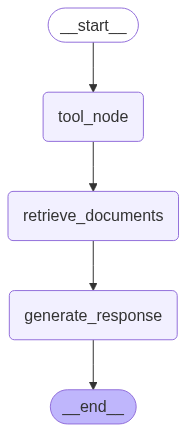

In [27]:
from langsmith import traceable
import operator
from langchain.schema import Document
from openai import OpenAI
from mem0 import MemoryClient
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, AnyMessage, get_buffer_string
from langgraph.graph import StateGraph, START, END
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from typing_extensions import TypedDict, Annotated
from typing import List
import nest_asyncio
import uuid


MODEL_PROVIDER = "openai"
MODEL_NAME = "gpt-4o-mini"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.
"""
thread_id = str(uuid.uuid4())
openai_client = OpenAI()
checkpointer = MemorySaver()
nest_asyncio.apply()
tools = [calculate_ei_benefit]
class GraphState(TypedDict):
    question: str
    messages: Annotated[List[AnyMessage], operator.add]
    documents: List[Document]
   


@tool
def calculate_ei_benefit(hourly_rate: float, weekly_hours: float, family_income: float = None, has_children: bool = False) -> float:
    """
    Calculate the estimated weekly EI benefit.

    :param hourly_rate: User's hourly wage
    :param weekly_hours: Number of hours worked per week
    :param family_income: Net family income (optional)
    :param has_children: Whether the user has children (optional)
    :return: Estimated weekly EI benefit
    """
    weekly_earnings = hourly_rate * weekly_hours
    benefit_rate = 0.55

    # Check for Family Supplement eligibility
    if family_income is not None and family_income <= 25921 and has_children:
        benefit_rate = 0.80

    weekly_benefit = weekly_earnings * benefit_rate
    return min(weekly_benefit, 695.00)

"""
retrieve_documents
- Returns documents fetched from a vectorstore based on the user's question
"""
@traceable(run_type="chain")
def retrieve_documents(state: GraphState):
    messages = state.get("messages", [])
    question = state["question"]
    documents = retriever.invoke(f"{get_buffer_string(messages)} {question}")
    return {"documents": documents}

"""
generate_response
- Calls `call_openai` to generate a model response after formatting inputs
"""
llm_with_tools = llm.bind_tools(tools)
@traceable(run_type="chain")
def generate_response(state: GraphState):
    question = state["question"]
    messages = state["messages"]
    documents = state["documents"]
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    rag_prompt_formatted = rag_chain.invoke({"input": question, "chat_history": messages , "context": formatted_docs}).text
    generation = llm_with_tools.invoke(question)
    return {"documents": documents, "messages": [HumanMessage(question), generation]}
    
tool_node = ToolNode(tools)
graph_builder = StateGraph(GraphState)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)
graph_builder.add_node("tool_node", tool_node)
graph_builder.add_edge(START, "tool_node")
graph_builder.add_edge("retrieve_documents", "generate_response")
graph_builder.add_edge("tool_node", "retrieve_documents")
graph_builder.add_edge("generate_response", END)

#simple_rag_graph = graph_builder.compile(checkpointer=checkpointer)
simple_rag_graph = graph_builder.compile()
display(Image(simple_rag_graph.get_graph().draw_mermaid_png()))


In [25]:
question = "Calculate my EI benefit with an hourly rate of 30, working 40 hours per week, a family income of 25000, and I have children."
simple_rag_graph.invoke({"question": question})['messages'][1].content

ValueError: No message found in input